In [1]:
from datetime import datetime, timedelta


In [2]:
import pandas_gbq

In [3]:
%run '/Users/ofirw/Downloads/Functions.ipynb'

In [4]:
df = query("""
 SELECT
    organizations.organization_id_wh AS merchant_id,
    organizations.organization_alias  AS merchant_name,
    organizations.country_name_org  AS country,
    ifnull((if(rbo_organization_kyb_status.oks_status IS NULL AND (case rapyd_merchants_portal_onboards.mpo_is_submitted
      WHEN TRUE then "Submitted" ELSE "Not Submitted" END)="Submitted","SUB",(IFNULL(rbo_organization_kyb_status.oks_status,'IDL')))),'IDL')  AS kyb_status,
    organizations.rbo_re_name AS rapyd_entity_name,
    ROUND(COALESCE(CAST( ( SUM(DISTINCT (CAST(ROUND(COALESCE( products_usage_tr.transaction_amount_usd *  products_usage_tr.is_tpv   ,0)*(1/1000*1.0), 9) AS NUMERIC) + (cast(cast(concat('0x', substr(to_hex(md5(CAST( ( concat(coalesce(products_usage_tr.action_token,""),coalesce(products_usage_tr.transaction_id_wh,""))  )   AS STRING))), 1, 15)) as int64) as numeric) * 4294967296 + cast(cast(concat('0x', substr(to_hex(md5(CAST( ( concat(coalesce(products_usage_tr.action_token,""),coalesce(products_usage_tr.transaction_id_wh,""))  )   AS STRING))), 16, 8)) as int64) as numeric)) * 0.000000001 )) - SUM(DISTINCT (cast(cast(concat('0x', substr(to_hex(md5(CAST( ( concat(coalesce(products_usage_tr.action_token,""),coalesce(products_usage_tr.transaction_id_wh,""))  )   AS STRING))), 1, 15)) as int64) as numeric) * 4294967296 + cast(cast(concat('0x', substr(to_hex(md5(CAST( ( concat(coalesce(products_usage_tr.action_token,""),coalesce(products_usage_tr.transaction_id_wh,""))  )   AS STRING))), 16, 8)) as int64) as numeric)) * 0.000000001) )  / (1/1000*1.0) AS NUMERIC), 0), 2) AS tpv_usd,
        (FORMAT_TIMESTAMP('%F %T', MAX(timestamp(FORMAT_TIMESTAMP('%F %T', products_usage_tr.transaction_created ))))) AS last_transaction,
        STRING_AGG(DISTINCT CAST(recon_merchants_transactions_agg.ra_transaction_type  AS STRING), ',') AS list_of_transaction_type
FROM `rapyd-bq-poc-2020.looker_wh.organizations`
     AS organizations
FULL OUTER JOIN `rapyd-bq-poc-2020.looker_wh.products_usage_tr`
     AS products_usage_tr ON organizations.organization_id=products_usage_tr.org_id_bytes
LEFT JOIN `rapyd-bq-poc-2020.looker_wh.mpo_with_verify_data`
     AS rapyd_merchants_portal_onboards ON rapyd_merchants_portal_onboards.mpo_organization_id_wh=organizations.organization_id_wh
            AND 1=1 -- no filter on 'is_deleted_filter_liquid.show_deleted_data'

LEFT JOIN `rapyd-bq-poc-2020.recon_ds.recon_merchants_transactions_agg`
     AS recon_merchants_transactions_agg ON recon_merchants_transactions_agg.ra_transaction_id_pk = products_usage_tr.ewallet_transaction_id and (recon_merchants_transactions_agg.ra_gateway_report_id is not null
    OR lower(recon_merchants_transactions_agg.ra_transaction_type) in ('correction_add_fee','correction_deduct_fee','interchange_fees','minimum_monthly_fee','offboarding_fee','scheme_fees', 'monthly_flat_fee'))

LEFT JOIN `looker_wh.rbo_organization_kyb_status`
     AS rbo_organization_kyb_status ON rbo_organization_kyb_status.oks_organization_id=organizations.organization_id
WHERE ((UPPER(( organizations.organization_type_name  )) = UPPER('Commercial'))) AND ((NOT (cast(organizations.is_test as bool) ) OR (cast(organizations.is_test as bool) ) IS NULL) AND ((( recon_merchants_transactions_agg.ra_transaction_timestamp  ) >= ((TIMESTAMP(DATETIME_ADD(DATETIME(TIMESTAMP_TRUNC(TIMESTAMP_TRUNC(CURRENT_TIMESTAMP(), DAY), MONTH)), INTERVAL -24 MONTH)))) AND ( recon_merchants_transactions_agg.ra_transaction_timestamp  ) < ((TIMESTAMP(DATETIME_ADD(DATETIME(TIMESTAMP(DATETIME_ADD(DATETIME(TIMESTAMP_TRUNC(TIMESTAMP_TRUNC(CURRENT_TIMESTAMP(), DAY), MONTH)), INTERVAL -24 MONTH))), INTERVAL 25 MONTH))))))) AND (((UPPER(( organizations.countries_merchants_country_region )) LIKE UPPER('%') OR (( organizations.countries_merchants_country_region ) IS NULL))) AND (((UPPER(( products_usage_tr.gateway_id  )) LIKE UPPER('%') OR (( products_usage_tr.gateway_id  ) IS NULL))) AND ((UPPER(( organizations.calc_entity )) LIKE UPPER('%') OR (( organizations.calc_entity ) IS NULL)))))
and recon_merchants_transactions_agg.ra_transaction_type in ('payout','payment')
GROUP BY
    1,
    2,
    3,
    4,
    5
ORDER BY
    7 DESC         
          """)
    
df.head(3)



Execution time = 0:03:46 minutes
------------------------------------
Rows = 484 | Columns = 8



,merchant_id,merchant_name,country,kyb_status,rapyd_entity_name,tpv_usd,last_transaction,list_of_transaction_type
0,035a6f7d-f92f-41c7-9d67-f9beff8a785e,Google Asia Pacific Pte. Ltd.,Singapore,APR,Rapyd Holdings Pte. Ltd.,175396493.583982000,2023-12-13 23:59:58,payment
1,9541d94e-4340-4ae1-9941-d28d90042fdb,Happymob Software Limited,U.K.,APR,Cash Dash UK Limited,9643217.427112000,2023-12-13 23:59:44,"payment,payout"
2,ddce1505-7870-4d74-b99b-137bac01b1d5,Viber Media S.a.r.l.,U.K.,APR,Cash Dash UK Limited,8099926.903768000,2023-12-13 23:59:37,"payout,payment"


In [27]:
df['last_transaction'] = pd.to_datetime(df['last_transaction'])


last_90_days = datetime.now() - timedelta(days=90)

# df['merchant_last_transaction_date'] = df.groupby('organizations_organization_id_wh')['products_usage_tr_last_transaction'].transform('max')
df['is_churn'] =  (df['last_transaction'] < last_90_days) 
df['is_churn'] = df['is_churn'].astype(int)

def reorder_values(value):
    if ',' in value:
        values = value.split(',')
        if len(values) == 2 and values[0] == 'payout' and values[1] == 'payment':
            return 'payment,payout'
    return value

# Apply the custom function to the column
df['list_of_transaction_type'] = df['list_of_transaction_type'].apply(reorder_values)

# Display the resulting DataFrame
print(df)


                              merchant_id                      merchant_name  \
0    035a6f7d-f92f-41c7-9d67-f9beff8a785e      Google Asia Pacific Pte. Ltd.   
1    9541d94e-4340-4ae1-9941-d28d90042fdb          Happymob Software Limited   
2    ddce1505-7870-4d74-b99b-137bac01b1d5               Viber Media S.a.r.l.   
3    c89e2b36-ec8a-4e58-81a5-029316f9079b  Yellow Social Interactive Limited   
4    a01c195f-5b15-4995-a747-3513cbaf8877                      B2Services OÜ   
..                                    ...                                ...   
479  3cc20399-c4e8-4fa5-afae-036b2cfcbc9d                     Sykurmolar ehf   
480  6603585f-aefc-451a-a3ae-33d415a624e3                       Gufudalurehf   
481  6128e64e-0250-4e6a-bdd5-7f64b12e6223               Jaki immobilien GmbH   
482  5af143bb-c7a6-4b0e-93aa-3578a16db425                          Ludus ehf   
483  a7207dce-0a4e-4ab4-a233-3f804e755205             Rakuten Travel Xchange   

       country kyb_status         rapyd

  kyb_status  is_churn
0        APR       388
1        DEC        90
2        IDL         3
3        SUB         3
[388  90   3   3 388  90   3   3]
[262   8   0   1 126  82   3   2]
[388, 90, 3, 3, 388, 90, 3, 3]


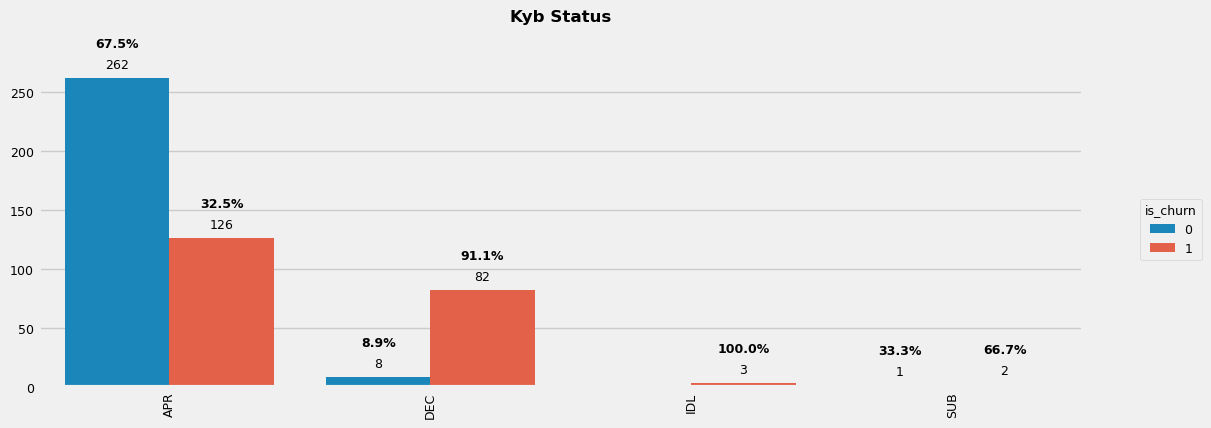

  list_of_transaction_type  is_churn
0                  payment       368
1           payment,payout        65
2                   payout        51
[368  65  51 368  65  51]
[205  46  20 163  19  31]
[368, 65, 51, 368, 65, 51]


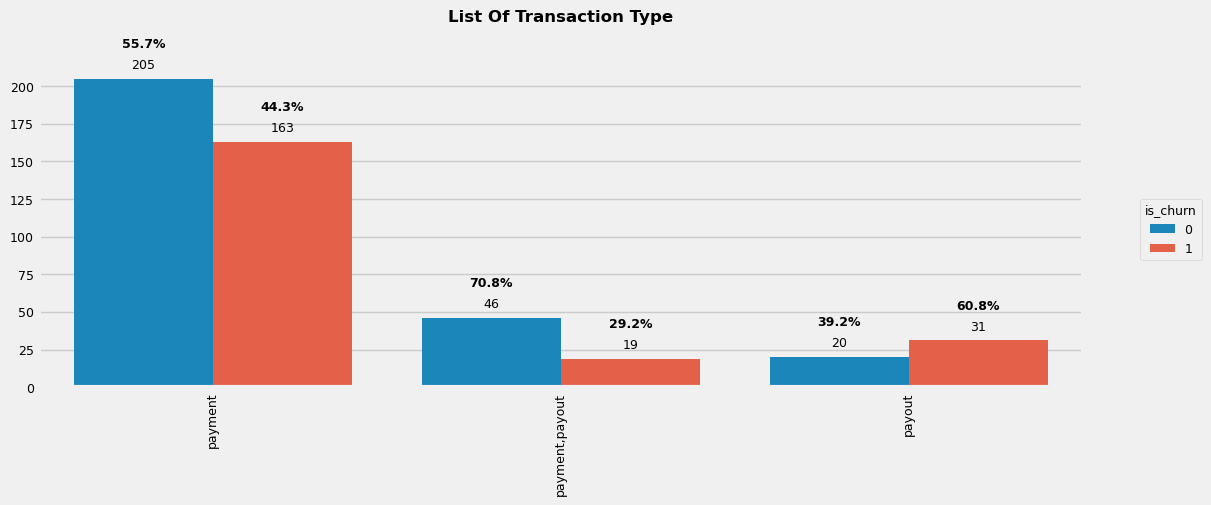

                                rapyd_entity_name  is_churn
0                            Cash Dash UK Limited        58
1                         Moment Holdings Limited         3
2                                    Neat Limited         2
3  RAPYD AGGREGATOR NETWORK INDIA PRIVATE LIMITED         1
4                RAPYD NETWORKS MEXICO SAPI DE CV        10
5                           Rapyd Colombia S.A.S.         2
6                                    Rapyd Europe       254
7               Rapyd Financial Technology US Inc        32
8                        Rapyd Holdings Pte. Ltd.       122
[ 58   3   2   1  10   2 254  32 122  58   3   2   1  10   2 254  32 122]
[ 27   3   2   0   7   1 153  20  58  31   0   0   1   3   1 101  12  64]
[58, 3, 2, 1, 10, 2, 254, 32, 122, 58, 3, 2, 1, 10, 2, 254, 32, 122]


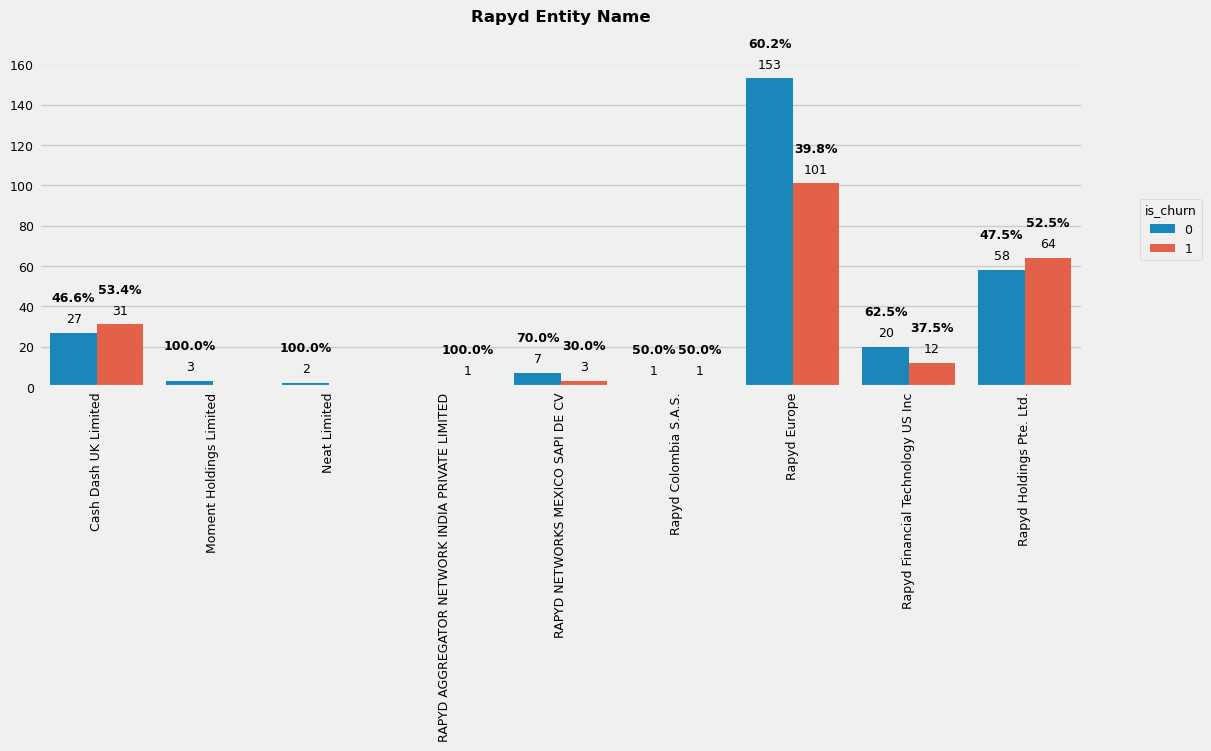

In [28]:
for col in ['kyb_status','list_of_transaction_type','rapyd_entity_name']:
    count_plot(df, col = col, hue = 'is_churn', figsize = (12,4), fontsize = 9, xticks_rot = 90)